In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import healpy as hp
import easygems.healpix as egh
import cartopy.crs as ccrs
import numpy as np
%run ~/hackathon-2025_project/hk25-AusNode-land/analysis/yll_functions.ipynb

In [24]:
# define paths
datapath = '/g/data/qx55/germany_node/d3hp003.zarr'
file = 'PT1H'
zoom = 'z7'
file_era5 = '/g/data/rt52/era5/single-levels/reanalysis/2t/2020/2t_era5_oper_sfc_20200101-20200131.nc'
era5_template = xr.open_dataset(file_era5).isel(time=0)

# define the fname
fpath = f'{datapath}/{file}_point_{zoom}_atm.zarr'

# open the zarr file
ds = xr.open_zarr(fpath).sel(time=slice('2020-03','2021-02'))
ds_djf = ds.sel(time=ds['time'].dt.month.isin([12, 1, 2]))

# what variables are there in the dataset?
for key, longname in ds.data_vars.items():
    print(f'{key}: {longname.long_name}')

'''
#### some variables of interest ####

hflsd: latent heat flux
hfssd: sensible heat flux
huss: specific humidity in 2m
mrso: Water content of soil layers
orog: surface altitude
pr: precipitation flux
rlds: surface downwelling longwave radiation
rldscs: surface downwelling clear-sky longwave radiation
rlus: surface upwelling longwave radiation
rsds: surface downwelling shortwave radiation
rsdscs: surface downwelling clear-sky shortwave radiation
rsus: surface upwelling shortwave radiation
sftlf: cell area fraction occupied by land including lakes
tas: temperature in 2m
tauu: u-momentum flux at the surface
tauv: v-momentum flux at the surface
ts: surface temperature
uas: zonal wind in 10m
vas: meridional wind in 10m
'''


orog: surface altitude
pr: precipitation flux
psl: mean sea level pressure
rlut: toa outgoing longwave radiation
rsut: toa outgoing shortwave radiation
sftgif: cell area fraction occupied by land ice
sftlf: cell area fraction occupied by land including lakes
ts: surface temperature
uas: zonal wind in 10m
vas: meridional wind in 10m


'\n#### some variables of interest ####\n\nhflsd: latent heat flux\nhfssd: sensible heat flux\nhuss: specific humidity in 2m\nmrso: Water content of soil layers\norog: surface altitude\npr: precipitation flux\nrlds: surface downwelling longwave radiation\nrldscs: surface downwelling clear-sky longwave radiation\nrlus: surface upwelling longwave radiation\nrsds: surface downwelling shortwave radiation\nrsdscs: surface downwelling clear-sky shortwave radiation\nrsus: surface upwelling shortwave radiation\nsftlf: cell area fraction occupied by land including lakes\ntas: temperature in 2m\ntauu: u-momentum flux at the surface\ntauv: v-momentum flux at the surface\nts: surface temperature\nuas: zonal wind in 10m\nvas: meridional wind in 10m\n'

In [25]:
era5_template

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2020-01-01
Data variables:
    t2m        (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-26 12:51:33 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20200101-20200131

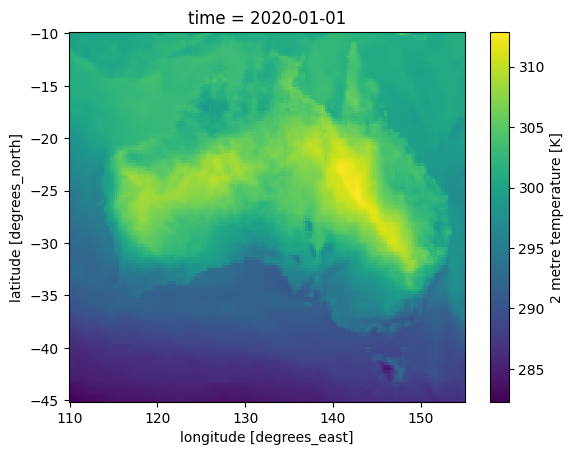

In [26]:
lonW = 110
lonE = 155
latN = -10
latS = -45

era5_region = era5_template.sel(latitude=slice(latN, latS), longitude=slice(lonW, lonE))
lat = era5_region.latitude.values
lon = era5_region.longitude.values
era5_region.t2m.plot()

In [27]:
land = ds_djf['sftlf']
#pr = xr.where(land >0.9, ds['pr'], np.nan)
pr = ds_djf['pr']

# nside for um simulation, it should be equal to 2**zoom
this_nside = hp.get_nside(land)

cells = get_nn_lon_lat_index(this_nside, lon, lat) 

cells

<xarray.DataArray (lat: 141, lon: 181)>
array([[ 86605,  86616,  86616, ..., 107087, 107087, 107085],
       [ 86605,  86605,  86610, ..., 107086, 107085, 107085],
       [ 86604,  86599,  86599, ..., 107084, 107084, 107084],
       ...,
       [156652, 156647, 156647, ..., 153884, 153885, 153879],
       [156646, 156647, 156647, ..., 153884, 153878, 153879],
       [156646, 156644, 156645, ..., 153875, 153878, 153878]])
Coordinates:
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -44.5 -44.75 -45.0
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0

In [28]:
land_regrided = land.isel(cell = cells) # regriding
land_regrided = land_regrided.rename({'lon': 'longitude', 'lat': 'latitude'}) # we need to change the names to match ERA5 data
pr_regrided = pr.isel(cell = cells)
pr_regrided = pr_regrided.rename({'lon': 'longitude', 'lat': 'latitude'}) # we need to change the names to match ERA5 data

pr_regrided

<xarray.DataArray 'pr' (time: 2160, latitude: 141, longitude: 181)>
dask.array<transpose, shape=(2160, 141, 181), dtype=float32, chunksize=(4, 141, 181), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-12-01 ... 2021-02-28T23:00:00
  * latitude   (latitude) float32 -10.0 -10.25 -10.5 ... -44.5 -44.75 -45.0
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 154.5 154.8 155.0
Attributes:
    grid_mapping:        crs
    hiopy::time_method:  point
    hiopy::nnn:          4
    hiopy::enable:       True
    standard_name:       pr
    units:               kg m-2 s-1
    short_name:          
    long_name:           precipitation flux

In [36]:
from timezonefinder import TimezoneFinder
import pytz  # or use zoneinfo for Python 3.9+
import pandas as pd

tf = TimezoneFinder()
tz = tf.timezone_at(lat=(latN+latS)/2, lng=(lonW+lonE)/2)
time_index = pd.DatetimeIndex(pr_regrided['time'].values).tz_localize('UTC').tz_convert(tz)

pr_regrided_LT = pr_regrided.copy()
pr_regrided_LT = pr_regrided_LT.assign_coords(time=time_index)
pr_hourly_clm = pr_regrided_LT.groupby('time.dt.hour').mean(dim='time')
pr_hourly_clm

AttributeError: 'IndexVariable' object has no attribute 'dt.hour'

AttributeError: 'IndexVariable' object has no attribute 'hour'